In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from  tensorflow import keras 
sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate

In [2]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(227,227),include_targets=True,num_outputs = 10)

augment Dataset
targetsis : True
adding targets to inputs
trainSize 45000
testSize 10000


In [3]:
train_ds

<BatchDataset element_spec=((TensorSpec(shape=(32, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 10), dtype=tf.float32, name=None)), TensorSpec(shape=(32, 10), dtype=tf.float32, name=None))>

In [4]:
loss_fn = brevis.utils.evidence_crossentropy(num_outputs=10)
model = brevis.BranchModel(name="../models/brevis_alex_Bflat.hdf5", custom_objects={})
           
# model.add_targets(10)
# model.add_branches(branches.branch.newBranch_flatten_evidence,
#                           ["max_pooling2d",
#                             "max_pooling2d_1",
#                             "dense"
#                           ],
#                           target_input=True,loop=False,num_outputs=10)
            
model.compile(loss=[loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="")
# model.summary()


preset: Other

preset: Other


In [5]:
# SVM reliability diagram with calibration
def classification(y, prob, bins =10):
    from sklearn.datasets import make_classification
    from sklearn.svm import SVC
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.model_selection import train_test_split
    from sklearn.calibration import calibration_curve
    from matplotlib import pyplot
    # generate 2 class dataset
    # X, y = make_classification(n_samples=1000, n_classes=2, weights=[1,1], random_state=1)
    # # split into train/test sets
    # trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
    # # fit a model
    # _model = SVC(gamma='scale')
    # calibrated = CalibratedClassifierCV(_model, method='sigmoid', cv=5)
    # calibrated.fit(trainX, trainy)
    # # predict probabilities
    # probs = calibrated.predict_proba(testX)[:, 1]
    # # reliability diagram
    # print(probs)
    # print(testy)
    # print(prob)
    linspace = np.linspace(0,1,num=bins)
    # pyplot.hist(prob,bins=linspace,density=False)
    
    fop, mpv = calibration_curve(y,prob, n_bins=bins, normalize=True)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot calibrated reliability
    pyplot.plot(mpv, fop, marker='.')
    pyplot.show()
    
# SVM reliability diagram with calibration
def cumulativeClassification(y, prob, bins =10):
    from sklearn.datasets import make_classification
    from sklearn.svm import SVC
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.model_selection import train_test_split
    from sklearn.calibration import calibration_curve
    from matplotlib import pyplot
    # generate 2 class dataset
    # X, y = make_classification(n_samples=1000, n_classes=2, weights=[1,1], random_state=1)
    # # split into train/test sets
    # trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
    # # fit a model
    # _model = SVC(gamma='scale')
    # calibrated = CalibratedClassifierCV(_model, method='sigmoid', cv=5)
    # calibrated.fit(trainX, trainy)
    # # predict probabilities
    # probs = calibrated.predict_proba(testX)[:, 1]
    # # reliability diagram
    # print(probs)
    # print(testy)
    # print(prob)
    linspace = np.linspace(0,1,num=bins)
    # pyplot.hist(prob,bins=linspace,density=False)
    accuracy = []
    throughputs = []
    for point in linspace:
        true = 0
        false = 0   
        throughput = 0
        for i, p in enumerate(prob):
            
            if p >= point:
                throughput = throughput + 1
                if y[i] ==True:
                    true = true +1
                if y[i] ==False: 
                    false = false + 1
        try:
            accuracy.append(true/(true+false))
            throughputs.append(throughput/len(prob))
            # print(point, throughput/len(prob))                
        except:
            # bins.append(0)
            pass
    # print(throughputs)
    pyplot.plot(linspace[:len(throughputs)], throughputs)
    
    fop, mpv = calibration_curve(y,prob, n_bins=bins, normalize=True)
    
    
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot calibrated reliability
    pyplot.plot(mpv, fop, marker='.')
    
    # fop, mpv = calibration_curve(y,prob, n_bins=bins, normalize=True)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot calibrated reliability
    pyplot.plot(linspace[:len(accuracy)], accuracy, marker='.')
    pyplot.show()
    

In [12]:
def getPredictions(model):
    stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
    #     train_ds, test_ds, validation_ds = (dataset)
   

    Results=[]
    Pred=[]
    Labels =[]
    
    Outputs = pd.DataFrame()
    pAcc=[]
    for i in range(num_outputs):
        Results.append([])
        Pred.append([])
        Labels.append([])
       


    for i, (x,y) in enumerate(test_ds):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        # print("pred", predictions)
        # print(y)
        # if num_outputs > 1:
        for k, outputs in enumerate(predictions):
            # print("output ", k, outputs)
            for j, prediction in enumerate(outputs):
                # print(prediction)
                # for pred
                Results[k].append(np.argmax(prediction))
                Pred[k].append((tf.reduce_sum(tf.nn.softplus(prediction)).numpy()))
                # Pred[k].append(np.amax(tf.nn.softmax(prediction)))
                Labels[k].append(np.argmax(y[j]))
        # else:
        # for j, prediction in enumerate(predictions):
        #     # for pred
        #     Results.append(np.argmax(prediction))
        #     Pred.append(np.amax(prediction))
        #     Labels.append(np.argmax(y[j]))

    # print(Results)
    # print(Pred)
    # print(Labels)
    # print(set(Results).intersection(Labels))
    
    
    
    Outputs=[]
    for j in range(num_outputs):
        df = pd.DataFrame({"x":Results[j],"y":Labels[j],"probs":Pred[j]})
        conditions = [df['x'] == df['y'],df['x'] != df['y']]
        choices = [1, 0]

        #create new column in DataFrame that displays results of comparisons
        df['testy'] = np.select(conditions, choices, default=None)

        Outputs.append(df)
    
    #define choices
    

    # df['testy'] = df.loc(df["x"] == df["y"])
        # print(i)
        # classDf = df.loc[(df['y'] == i)]
    return Outputs
    # print(list(range(100)))
    # plot_calibration_curve(Labels,Results,list(range(100)))

In [13]:
outputs = getPredictions(model)
for i, output in enumerate(outputs):
    print(model.outputs[i].name)
    display(output)

outputs 4
dense_2/Softmax:0f 312


,x,y,probs,testy
0,3,3,7.511764,1
1,8,8,7.544139,1
2,1,8,7.493516,0
3,0,0,7.550720,1
4,6,6,7.528280,1
...,...,...,...,...
9979,3,3,7.548354,1
9980,0,0,7.550821,1
9981,4,4,7.550796,1
9982,6,2,7.548407,0


branch_softmax/MatMul:0


,x,y,probs,testy
0,3,3,0.029661,1
1,8,8,0.034209,1
2,0,8,0.129310,0
3,0,0,0.047868,1
4,4,6,0.124680,0
...,...,...,...,...
9979,5,3,0.037930,0
9980,0,0,0.025677,1
9981,4,4,0.014549,1
9982,6,2,0.093138,0


branch_softmax_1/MatMul:0


,x,y,probs,testy
0,3,3,0.093618,1
1,8,8,0.012018,1
2,0,8,0.006936,0
3,0,0,0.002731,1
4,6,6,0.001396,1
...,...,...,...,...
9979,3,3,0.033821,1
9980,0,0,0.000964,1
9981,4,4,0.080475,1
9982,6,2,0.052598,0


branch_softmax_2/MatMul:0


,x,y,probs,testy
0,3,3,0.427134,1
1,8,8,0.148013,1
2,1,8,0.011985,0
3,0,0,0.943825,1
4,6,6,0.035353,1
...,...,...,...,...
9979,3,3,0.587510,1
9980,0,0,0.286374,1
9981,4,4,1.314296,1
9982,6,2,0.177692,0


threshold 0.04188192


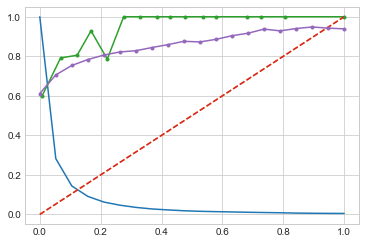

-----------------
rollover enabled, 6593 predictions provided
threshold 0.027722403


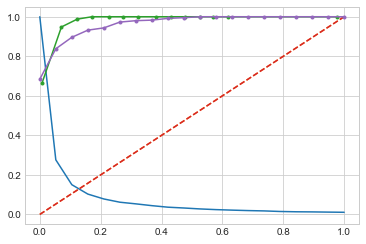

-----------------
rollover enabled, 3833 predictions provided
threshold 0.15268227


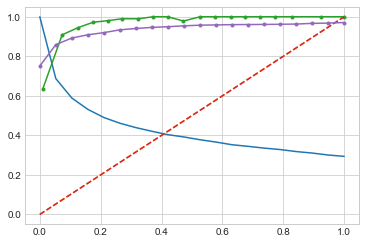

-----------------
rollover enabled, 1783 predictions provided
threshold 0


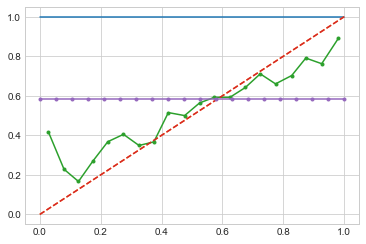

-----------------
thresholds [0.04188192, 0.027722403, 0.15268227, 0]
input_predictions [9984, 6593, 3833, 1783]
Accepted_list [3391, 2760, 2050, 1783]
Acceptance_correct [2349, 2183, 1862, 1045]
overall Accuracy 0.7450921474358975
branch_cost [1635737016, 4188694680, 164195662250, 203907310492]
base cost:  373927404438  total cost: 1125185198592
cost difference:  0.33232520735778776


In [18]:
rollOver_indices = pd.Index([])
_predictions = outputs.copy()
    # print(_branch_predictions)
_predictions.append(_predictions.pop(0))
Accepted_df = pd.DataFrame()

Accepted_list =[]
Acceptance_correct =[]
Input_predictions =[]
# Branch_cost =[17443270,29419724,108215257,141851611] #flat exit costs
Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

Base_cost = 112698838
Branch_flops = []
Thresholds=[]

Results=[]
for i, output in enumerate(_predictions):    
    if len(rollOver_indices)>0:
        print("rollover enabled, {} predictions provided".format(len(rollOver_indices)))
        output = output.iloc[rollOver_indices]
    # print(output['probs'])
    # print(output)
    from matplotlib import pyplot
    # hist = output.hist(bins=10)
    # print(model.output[i].name)
    mean = output.loc[(output['testy'] == False)].groupby("testy")["probs"].mean().iloc[0]
    std = output.loc[(output['testy'] == False)].groupby("testy")["probs"].std().iloc[0]
    threshold = mean
    # threshold = 0.05
    if i == len(_predictions)-1:
        threshold = 0
    print("threshold", threshold)
    Thresholds.append(threshold)
    Accepted = output.loc[(output["probs"] >= threshold)]
    # print("Accuracy", len(Accepted), Accepted.groupby("testy").count())
    Rejected = output.loc[(output["probs"] < threshold)]
    rollOver_indices = Rejected.index
    # Accepted_df = pd.concat([Accepted_df, Accepted])
    Results.append(Accepted)
    
    Accepted_list.append(len(Accepted))
    Acceptance_correct.append(len(Accepted.loc[(Accepted['testy'] == True)]))
    Input_predictions.append(len(output))
    Branch_flops.append(len(Accepted)* Branch_cost[i]) 
    
    cumulativeClassification(output['testy'].tolist(),output['probs'].tolist(),20)
    print("-----------------")
_Results = pd.concat(Results)
# print(_Results)
# print(_Results.groupby("testy").count())
print("thresholds", Thresholds)
print("input_predictions",Input_predictions)
print("Accepted_list",Accepted_list)
print("Acceptance_correct",Acceptance_correct)
print("overall Accuracy", sum(Acceptance_correct)/sum(Accepted_list))
print("branch_cost", Branch_flops)
print("base cost: ",sum(Branch_flops)," total cost:", sum(Accepted_list)*Base_cost)
print("cost difference: ",sum(Branch_flops)/(sum(Accepted_list)*Base_cost))


[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
      x  y     probs testy
0     3  3  0.029661     1
1     8  8  0.034209     1
2     0  8  0.129310     0
3     0  0  0.047868     1
4     4  6  0.124680     0
...  .. ..       ...   ...
9979  5  3  0.037930     0
9980  0  0  0.025677     1
9981  4  4  0.014549     1
9982  6  2  0.093138     0
9983  9  0  0.049781     0

[9984 rows x 4 columns]
0
threshold 0.05
Accuracy 2910           x     y  probs
testy                   
0       863   863    863
1      2047  2047   2047


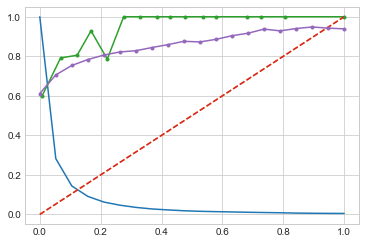

-----------------
rollover enabled, 7074 predictions provided
      x  y     probs testy
0     3  3  0.093618     1
1     8  8  0.012018     1
3     0  0  0.002731     1
5     6  6  0.472186     1
6     1  1  0.003592     1
...  .. ..       ...   ...
9978  4  7  0.006800     0
9979  3  3  0.033821     1
9980  0  0  0.000964     1
9981  4  4  0.080475     1
9983  0  0  0.024902     1

[7074 rows x 4 columns]
1
threshold 0.05
Accuracy 2056           x     y  probs
testy                   
0       333   333    333
1      1723  1723   1723


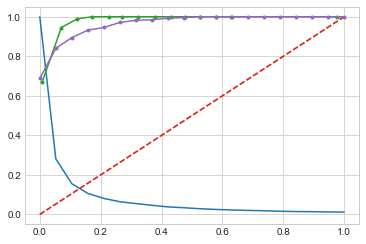

-----------------
rollover enabled, 5018 predictions provided
      x  y     probs testy
1     8  8  0.148013     1
3     0  0  0.943825     1
6     1  1  0.015622     1
7     6  6  0.028943     1
10    0  0  0.050199     1
...  .. ..       ...   ...
9977  5  5  0.358093     1
9978  7  7  0.009501     1
9979  3  3  0.587510     1
9980  0  0  0.286374     1
9983  1  0  1.857884     0

[5018 rows x 4 columns]
2
threshold 0.05
Accuracy 3584           x     y  probs
testy                   
0       525   525    525
1      3059  3059   3059


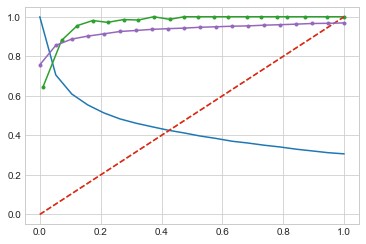

-----------------
rollover enabled, 1434 predictions provided
      x  y     probs testy
6     1  1  7.498482     1
7     6  6  7.516326     1
35    8  2  7.503880     0
37    9  1  7.524551     0
44    0  0  7.474074     1
...  .. ..       ...   ...
9957  8  0  7.466775     0
9965  4  2  7.523261     0
9968  5  3  7.530729     0
9972  4  4  7.539189     1
9978  4  7  7.488727     0

[1434 rows x 4 columns]
3
threshold 0
Accuracy 1434          x    y  probs
testy                 
0      662  662    662
1      772  772    772


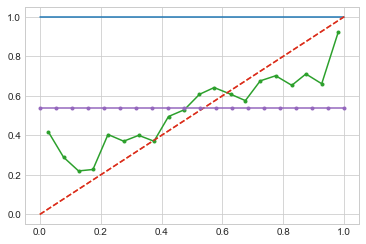

-----------------
      x  y     probs testy
2     0  8  0.129310     0
4     4  6  0.124680     0
8     7  3  0.093039     0
9     1  1  0.263427     1
11    9  9  0.050432     1
...  .. ..       ...   ...
9957  8  0  7.466775     0
9965  4  2  7.523261     0
9968  5  3  7.530729     0
9972  4  4  7.539189     1
9978  4  7  7.488727     0

[9984 rows x 4 columns]
          x     y  probs
testy                   
0      2383  2383   2383
1      7601  7601   7601


In [17]:
print( np.linspace(0,1,num=20))

rollOver_indices = pd.Index([])
_predictions = outputs.copy()
    # print(_branch_predictions)
_predictions.append(_predictions.pop(0))
Accepted_df = pd.DataFrame()
Results=[]
for i, output in enumerate(_predictions):
    if len(rollOver_indices)>0:
        print("rollover enabled, {} predictions provided".format(len(rollOver_indices)))
        output = output.iloc[rollOver_indices]
    # print(output['probs'])
    print(output)
    from matplotlib import pyplot
#     linspace = np.linspace(0,1,num=10)
#     pyplot.hist(output['probs'].tolist(),bins=linspace,density=True)
    
#     pyplot.plot([0, 1], [0, 1], linestyle='--')
#     # pyplot.plot(mpv, fop, marker='.')
#     pyplot.show()

    # hist = output.hist(bins=10)
    # print(model.output[i].name)
    mean = output.loc[(output['testy'] == False)].groupby("testy")["probs"].mean().iloc[0]
    std = output.loc[(output['testy'] == False)].groupby("testy")["probs"].std().iloc[0]
    threshold = mean+std
    print(i)
    threshold = 0.05
    if i == len(_predictions)-1:
        threshold = 0
    print("threshold", threshold)
    Accepted = output.loc[(output["probs"] >= threshold)]
    print("Accuracy", len(Accepted), Accepted.groupby("testy").count())
    Rejected = output.loc[(output["probs"] < threshold)]
    rollOver_indices = Rejected.index
    # Accepted_df.concat(Accepted)
    Results.append(Accepted)
    cumulativeClassification(output['testy'].tolist(),output['probs'].tolist(),20)
    # try:
    #     Accepted = output.loc[(output["probs"] >= 0.78947368) & (output["probs"] <= 0.84210526)]
    # # Accepted = output.loc[(output['probs'] >= False) & (output["probs"] <= 0)]
    #     # print(Accepted)
    #     # print(Accepted.groupby("testy").count()['x'][1]/(Accepted.groupby("testy").count()['x'][1]+Accepted.groupby("testy").count()['x'][0]))
    # except:
    #     pass
    print("-----------------")
_Results = pd.concat(Results)
print(_Results)
print(_Results.groupby("testy").count())

In [16]:
from sklearn.neighbors import KernelDensity
import numpy as np
for i, output in enumerate(outputs):
    X = 
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
    kde.score_samples(X)


SyntaxError: invalid syntax (Temp/ipykernel_22564/3495499637.py, line 4)

[ 1.3315865   0.71527897 -1.54540029 ...  5.74446677  6.22449239
  8.42055014]


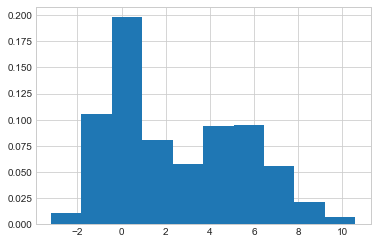

In [131]:
import matplotlib.pyplot as plt
rng = np.random.RandomState(10)  # deterministic random data
a = np.hstack((rng.normal(size=1000),
               rng.normal(loc=5, scale=2, size=1000)))
print(a)
_ = plt.hist(a, bins=10,density=True)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.show()